# Statistical Analysis
- Spearman Correlation
- Heatmap Visualization

> **Note:**  
> This notebook uses the **PSEN1_Petit et al.** dataset for correlation analysis and visualization.  
> To analyze a different dataset, update the file path, column names, and figure titles as needed.

In [43]:
# ==============================================================
# 🧩 PSEN1_Petit_et_al Variant Predictors vs. Experimental Outcomes
# Spearman Correlation Analysis + Seaborn Heatmap Visualization
# ==============================================================

In [44]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# --- 2️⃣ Load Dataset ---
df = pd.read_csv("raw_data/PSEN1_Petit.csv")
df # Display the dataset

,Variants,Mutation,Aβ37 [%],Aβ37 SD,Aβ38 [%],Aβ38 SD,Aβ40 [%],Aβ40 SD,Aβ42 [%],Aβ42 SD,...,DANN_rankscore,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding
0,PSEN1:p.Ala79Val,A79V,2.53,0.53,15.85,0.96,69.46,4.14,11.84,4.49,...,0.98171,0.928313,0.91201,D,0.837492,0.88323,9.558504,0.766865,0.87344,9.212799
1,PSEN1:p.Val89Leu,V89L,2.81,1.04,11.74,3.93,70.49,2.96,14.66,3.33,...,0.91218,0.945304,0.95328,D,1.007236,0.95941,14.151250,0.930148,0.96740,15.105730
2,PSEN1:p.Phe105Cys,F105C,5.79,0.27,10.07,0.79,74.31,0.84,9.83,0.60,...,0.64329,0.893810,0.83153,D,0.798625,0.85945,8.753408,0.737464,0.85136,8.515300
3,PSEN1:p.Leu113Pro,L113P,11.33,5.55,10.76,3.37,48.39,14.48,29.51,9.06,...,0.97507,0.980619,0.99848,D,0.817390,0.87113,9.130086,0.754333,0.86405,8.902781
4,PSEN1:p.Tyr115His,Y115H,6.91,3.50,8.43,1.53,59.37,4.35,23.63,5.41,...,0.92075,0.964887,0.98705,D,0.865128,0.89897,10.188210,0.750018,0.86083,8.800745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# --- 3️⃣ Define Helper Functions ---
def coerce_numeric(s: pd.Series) -> pd.Series:
    """Convert a Series to numeric, removing symbols like '%' and ','."""
    if s.dtype.kind in "biufc":
        return s.astype(float)
    cleaned = (
        s.astype(str)
         .str.replace(r'[%\s]', '', regex=True)
         .str.replace(',', '', regex=False)
         .replace({'nan': np.nan, 'None': np.nan})
    )
    return pd.to_numeric(cleaned, errors="coerce")

def pairwise_corr(x: pd.Series, y: pd.Series, method="spearman"):
    """Compute correlation and p-value safely (drops NaNs, requires n≥3)."""
    x_num, y_num = coerce_numeric(x), coerce_numeric(y)
    mask = np.isfinite(x_num.values) & np.isfinite(y_num.values)
    n = int(mask.sum())
    if n < 3:
        return np.nan, np.nan, n
    if method == "spearman":
        r, p = stats.spearmanr(x_num.values[mask], y_num.values[mask])
    else:
        r, p = stats.pearsonr(x_num.values[mask], y_num.values[mask])
    return float(r), float(p), n

# --- 4️⃣ Define Predictors and Outcomes ---
predictors = [c for c in df.columns if c.endswith("_rankscore")]
outcomes = ["Aβ37 [%]", "Aβ38 [%]", "Aβ40 [%]", "Aβ42 [%]", "Aβ43 [%]"]
outcomes = [c for c in outcomes if c in df.columns]

if not predictors:
    raise ValueError("No predictor columns ending with '_rankscore' found.")
if not outcomes:
    raise ValueError("Expected outcome columns not found in dataset.")

print(f"✅ Using {len(predictors)} predictors and {len(outcomes)} outcomes.\n")

✅ Using 37 predictors and 5 outcomes.



In [46]:
# --- 5️⃣ Compute Correlations ---
rows = []
for pred in predictors:
    for out in outcomes:
        rho, pval, n = pairwise_corr(df[pred], df[out], method="spearman")
        rows.append({"predictor": pred, "outcome": out, "rho": rho, "p_value": pval, "n": n})

corr_df = pd.DataFrame(rows)

In [47]:
# --- 6️⃣ Maintain Consistent Ordering ---
pred_order = CategoricalDtype(categories=predictors, ordered=True)
out_order  = CategoricalDtype(categories=outcomes, ordered=True)
corr_df["predictor"] = corr_df["predictor"].astype(pred_order)
corr_df["outcome"]   = corr_df["outcome"].astype(out_order)
corr_df = corr_df.sort_values(["outcome", "predictor"]).reset_index(drop=True)

# --- 7️⃣ Save Results ---
output_file = "processed_data/PSEN1_Petit_et_al_correlations.csv" # Change the title as needed
corr_df.to_csv(output_file, index=False)
print(f"📁 Saved correlation results to '{output_file}' ({len(corr_df)} rows).")

📁 Saved correlation results to 'processed_data/PSEN1_Petit_et_al_correlations.csv' (185 rows).


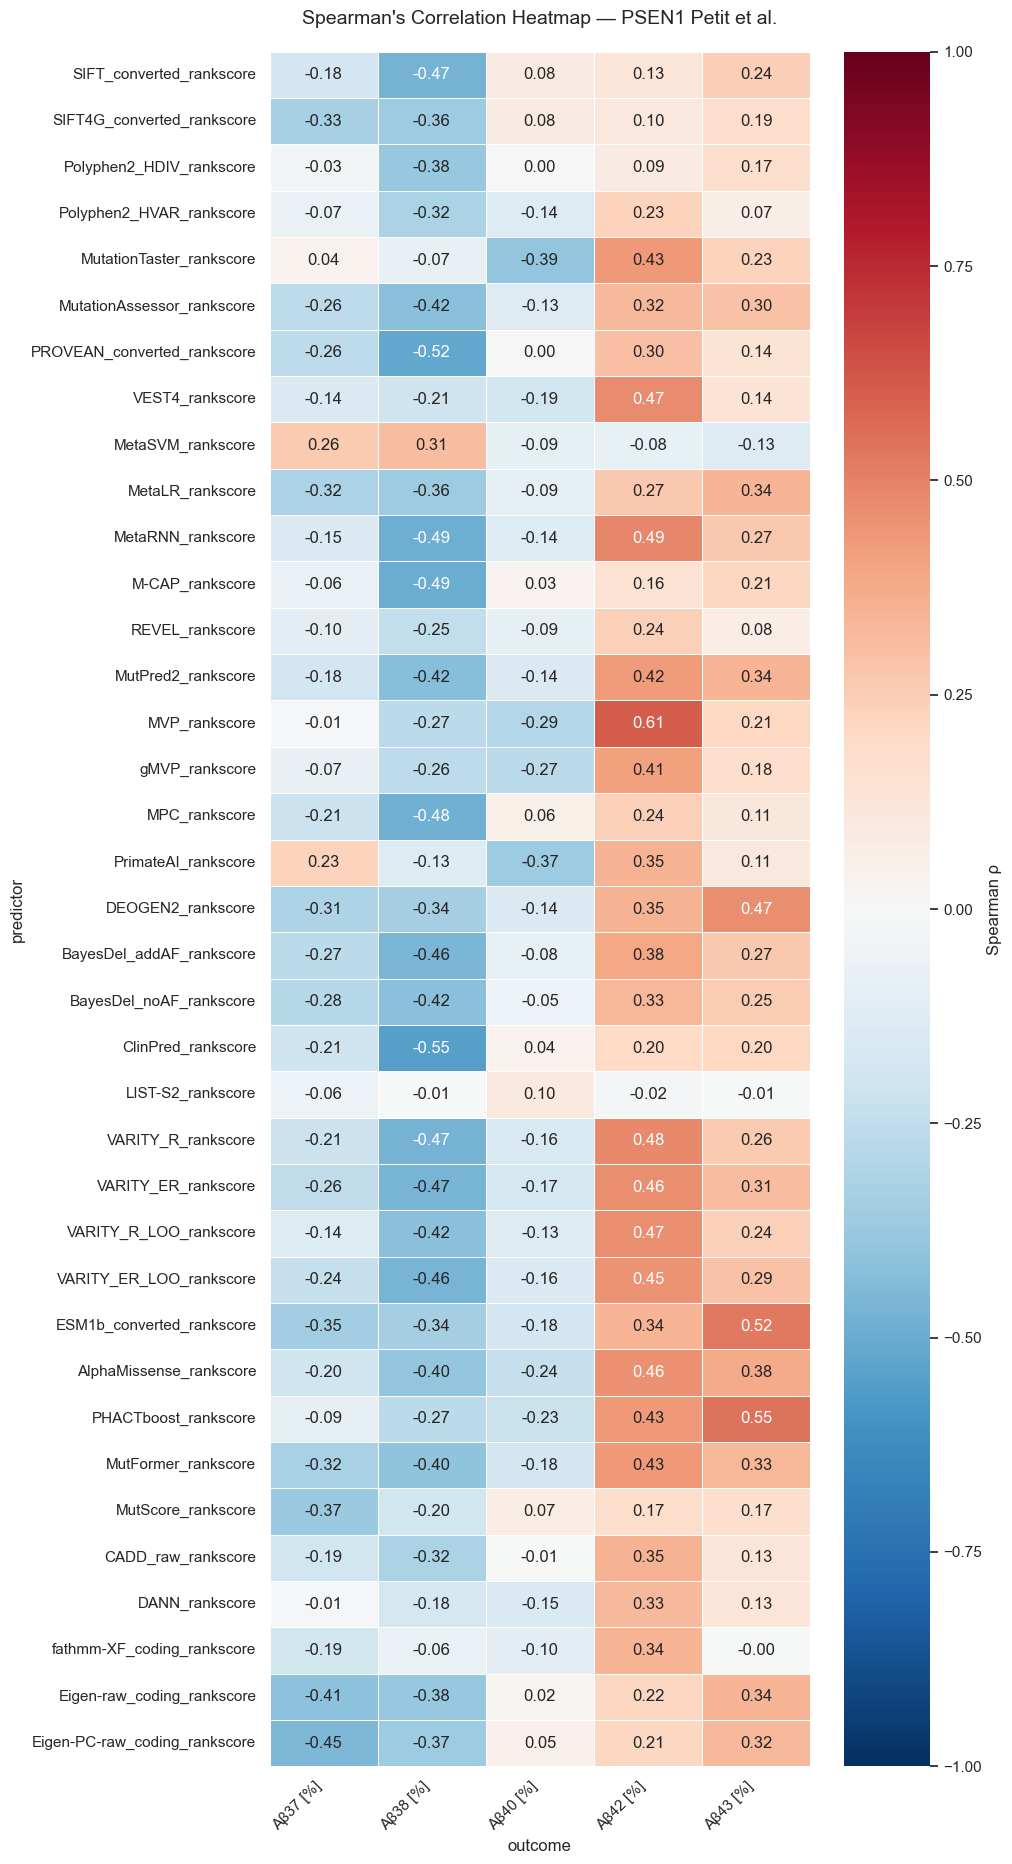

In [48]:
# --- 8️⃣ Prepare Data for Heatmap ---
rho_matrix = corr_df.pivot(index="predictor", columns="outcome", values="rho")

# --- 9️⃣ Plot Spearman Correlation Heatmap ---
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(figsize=(10, 0.4 * len(predictors) + 4))

sns.heatmap(
    rho_matrix,
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman ρ"},
    ax=ax
)

ax.set_title("Spearman's Correlation Heatmap — PSEN1 Petit et al.", fontsize=14, pad=20) # Change the title as needed
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

In [49]:
# --- 🔟 Save Figure ---
fig_name = "figures/PSEN1_Petit_heatmap.png"
fig.savefig(fig_name, dpi=600, bbox_inches="tight", facecolor="white")

print(f"📊 Saved heatmap → '{fig_name}' ({len(predictors)} predictors × {len(outcomes)} outcomes)")

📊 Saved heatmap → 'figures/PSEN1_Petit_heatmap.png' (37 predictors × 5 outcomes)
